# Project Presentation

## Project Objectives

* Create and tune the following models:
    * ARIMA
    * Prohpet
    * Decision Trees
* Evaluate model performance and compare different approaches
    * standardise evaluation against train/validation split
    * build reusable code for this
    * how close are we to competitive, what would we need to get there?
* Agile ways of working
    * Build reusable code
        * modular
        * organized
        * commented
        * accessible on git
    * define and adhere to role responsibilities


# Import

In [1]:
# Standard Imports
import os
import pandas as pd
import numpy as np
import sys
import gc
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings("ignore")

# Modelling
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import (train_test_split, GridSearchCV)
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# Tuning Hyper-parameters
from skopt import gp_minimize


# Visualisation
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
# Src modules
sys.path.append(os.path.dirname(os.getcwd())) # Add the parent directory to the Python path so we can import src modules
from src.arima import arima_trial
from src.data_setup import *
from src.model_evaluation import *
from src.model_evaluation import model_eval_pipeline,calc_root_mean_squared_error,calc_root_mean_squared_log_error,rmsle_func,rmsle_lgbm
from src.visualisation import *
from src.decision_tree import *
from src.model_utils import *


# Data Load

### Load and Transform

In [2]:
# load train,val and test data
train, test, stores, transactions = get_data()

# Load data used for modeling
#data = get_oil_holiday_data()
#df_data=Transform_Data_For_DT(data,60,True)
#df_data_feats=DT_features(df_data,False)

# Save data to pickle files
#df_data.to_pickle(DATA_PATH/'processed/DT.pkl')
#df_data_feats.to_pickle(DATA_PATH/'processed/DT_Features.pkl')
#data.to_pickle(DATA_PATH/'processed/Data.pkl')

# Load data if it already exists
df_data=pickle.load(open(DATA_PATH/'processed/DT.pkl','rb'))
df_data_feats=pickle.load(open(DATA_PATH/'processed/DT_Features.pkl','rb'))
data=pickle.load(open(DATA_PATH/'processed/Data.pkl','rb'))

loading pickled dataframes...


### Data Preprocessing

In [3]:
# Get Train and test data
train = data[data['is_test']==False]
train=train.drop(columns={'is_test'})
test = data[data['is_test']==True]
test=test.drop(columns={'is_test'})

# Get Train and Test data features
df_data_feats = df_data_feats.astype({'target': 'float'})
df_feats = df_data_feats[df_data_feats['is_test']==False]
df_train = df_data[df_data['is_test']==False]
df_test_feats = df_data_feats[df_data_feats['is_test']==True]
df_test = df_data[df_data['is_test']==True]

# Remove the is_test column
df_feats=df_feats.drop(columns={'is_test'})
df_train=df_train.drop(columns={'is_test'})
df_test=df_test.drop(columns={'is_test'})
df_test_feats=df_test_feats.drop(columns={'is_test'})

#Label Encode the categorical columns
cat_list=['family','city','state','type']
df_le=pd.DataFrame()
for x in cat_list:
    list =train[x].unique()
    x_le = pd.DataFrame(list, columns=[x])
    le=LabelEncoder()
    x_le[x+'_le']=le.fit_transform(x_le[x])
    df_le=df_le.append(x_le)

###  Create Train and Val

In [4]:
#Check on date format and unrequired columns
df_train['date']= pd.to_datetime(df_train['date'])
df_feats['date']= pd.to_datetime(df_feats['date'])
try:
    df_train=df_train.drop(columns={'Unnamed: 0'})
except: 
    df_train=df_train
try: 
    df_feats=df_feats.drop(columns={'Unnamed: 0'})
except:
    df_feats=df_feats

#Create the split train/validation
df_training,df_validation=train_val_split(df_train,2)
df_feats_use,df_feats_validation=train_val_split(df_feats,2)

#Remove column for features dataframe - Separate X and Y
cols = [col for col in df_feats.columns if col not in ['date', 'id', "sales", "day",'target']]
Y_train = df_feats_use['sales']
X_train = df_feats_use[cols]
Y_val = df_feats_validation['sales']
X_val = df_feats_validation[cols]

# Seasonality EDA

In [11]:
# Looking at daily sales
daily_sales = train.groupby('date')['sales'].sum().reset_index()

<Figure size 640x480 with 0 Axes>

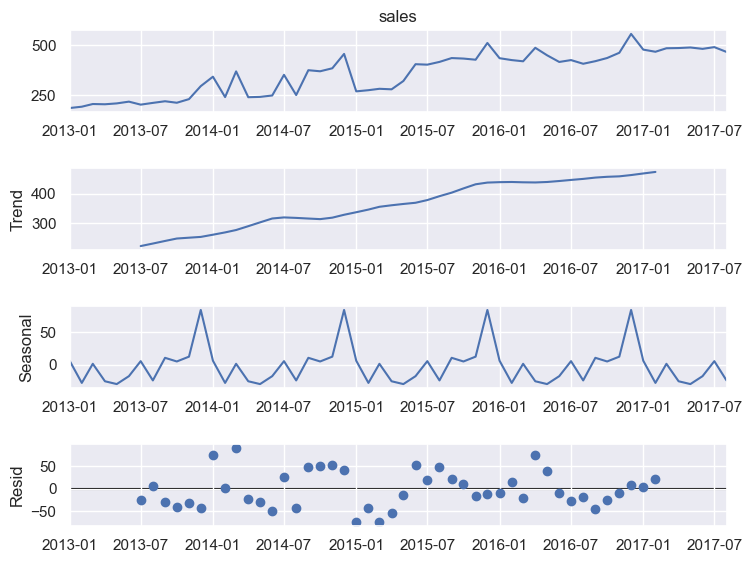

In [12]:
# Train decomposition 
train_plot = train.set_index('date')
y = train_plot['sales'].resample('MS').mean() 

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(8, 6)

In [13]:
# sales over time
px.line(daily_sales, x='date', y='sales',title = "Daily Sales over Time")

In [14]:
# examine sales by category
for col in ['store_nbr', 'family']:
    plot_sales_by(train, col)

In [15]:
# Plot daily sales by year and day of the week
grouped = train.groupby(['year', 'day_of_week'])['sales'].mean().reset_index()

# Create a line chart
fig = px.line(grouped, x="day_of_week", y="sales" , color="year", title="Average sales by year and day_of_week")
# Set xticks
fig.update_layout(
    xaxis=dict(
        tickvals=list(range(1, 8)),  # Specify tick values
        ticktext=['mon', 'tues', 'weds', 'thurs', 'fri', 'sat', 'sun']  # Specify tick labels
    )
)
# Show the chart
fig.show()

TypeError: 'Categorical' object is not callable

The data exhibits a trend by day of the week

In [ ]:
# Plot daily sales by month and day of the week
grouped = train.groupby(['month', 'day_of_week'])['sales'].mean().reset_index()

# Create a line chart
fig = px.line(grouped, x="day_of_week", y="sales" , color="month", title="Average sales by month and day_of_week")

# Set xticks
fig.update_layout(
    xaxis=dict(
        tickvals=list(range(1, 8)),  # Specify tick values
        ticktext=['mon', 'tues', 'weds', 'thurs', 'fri', 'sat', 'sun']  # Specify tick labels
    )
)
# Show the chart
fig.show()

Within any given month, the same weekly trend appears to hold true.

# Interactive EDA

In [ ]:
generate_interactive_treemap(train,10, [ 'month', 'family','store_nbr'],'sales','sales',3,'Blues')

# Modeling

In [5]:
# Define local evaluation function
def lgbm_evaluation(params):
    num_leaves, learning_rate, max_depth, feature_fraction, bagging_fraction, bagging_freq, min_data_in_leaf = params
    
    model = lgb.LGBMRegressor(
        boosting_type='gbdt',
        objective='regression',  # Use 'regression' for regression
        metric='None',           # We set metric to 'None' since we'll use our custom evaluation function
        num_leaves=int(num_leaves),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        feature_fraction=feature_fraction,
        bagging_fraction=bagging_fraction,
        bagging_freq=int(bagging_freq),
        min_data_in_leaf=int(min_data_in_leaf),
        verbose=-100
    )
    params = model.get_params()
    aliases = [
        {'min_child_weight', 'min_sum_hessian_in_leaf'},
        {'min_child_samples', 'min_data_in_leaf'},
        {'colsample_bytree', 'feature_fraction'},
        {'subsample', 'bagging_fraction'},
        {'subsample_freq','bagging_freq'}
    ]
    for alias in aliases:
        if len(alias & set(params)) == 2:
            arg = np.random.choice(sorted(alias))
            params[arg] = None
    model = lgb.LGBMRegressor(**params)

    model.fit(X_train_temp, Y_train_temp, verbose=False)
    y_pred = model.predict(X_val_temp)

    # Calculate the RMSLE score
    rmsle_score = rmsle_func(Y_val_temp, y_pred)

    # Return the RMSLE score
    return rmsle_score

## Train the models

We are training 33 models, 1 per family and validate the RMSLE score 

In [6]:
#Define paramaters
SEARCH_PARAMS = {}

FIXED_PARAMS={'objective': 'regression',
              'metric': 'custom',
              'boosting':'dart',
              'min_gain_to_split':0.01,
              'num_boost_round':1000,
              'early_stopping_rounds':100}
param = dict(SEARCH_PARAMS,**FIXED_PARAMS)

cols_no_fam = [col for col in df_feats.columns if col not in ['date', 'id', "sales", "day",'target','family']] # List of columns we want to keep as features

# Loop through families
for fam in df_feats_use['family'].unique():
    # Create temp dataframes
    temp=df_feats_use[df_feats_use['family']==fam]
    temp_val=df_feats_validation[df_feats_validation['family']==fam]
    Y_train_temp = temp['sales']
    X_train_temp = temp[cols_no_fam]
    Y_val_temp = temp_val['sales']
    X_val_temp = temp_val[cols_no_fam]

    # Define the space our tuning will operate
    space = [
        (10, 200),  # num_leaves
        (0.01, 0.5),  # learning_rate
        (5, 100),  # max_depth
        (0.1, 0.9),  # feature_fraction
        (0.1, 0.9),  # bagging_fraction
        (0, 10),  # bagging_freq
        (20, 200)  # min_data_in_leaf
    ]
    # Perform Bayesian Optimization to find the best hyperparameters
    result = gp_minimize(lgbm_evaluation, space, n_calls=100, random_state=42)

    # Extract the best hyperparameters
    best_params = {
        'num_leaves': int(result.x[0]),
        'learning_rate': result.x[1],
        'max_depth': int(result.x[2]),
        'feature_fraction': result.x[3],
        'bagging_fraction': result.x[4],
        'bagging_freq': int(result.x[5]),
        'min_data_in_leaf': int(result.x[6])
    }

    # Update param list
    param = dict(best_params,**FIXED_PARAMS)

    # Create Train and Val dataset
    lgbtrain = lgb.Dataset(data=X_train_temp, label=Y_train_temp, feature_name=cols_no_fam)
    lgbval = lgb.Dataset(data=X_val_temp, label=Y_val_temp, reference=lgbtrain, feature_name=cols_no_fam)

    # Train the model
    model = lgb.train(params=param,
                    train_set=lgbtrain,
                    valid_sets=[lgbtrain, lgbval],
                    num_boost_round=FIXED_PARAMS['num_boost_round'],
                    early_stopping_rounds=FIXED_PARAMS['early_stopping_rounds'],
                    feval=rmsle_lgbm,
                    verbose_eval=50)

    # Save the model
    save_model(DECISIONTREE_PATH,model,f'lgbm_valid_{fam}.pkl')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 98
[LightGBM] [Info] Start training from score 6.155503
[50]	training's rmsle: 0.564851	valid_1's rmsle: 0.528937
[100]	training's rmsle: 0.558957	valid_1's rmsle: 0.521671
[150]	training's rmsle: 0.555048	valid_1's rmsle: 0.523032
[200]	training's rmsle: 0.546891	valid_1's rmsle: 0.521328
[250]	training's rmsle: 0.539309	valid_1's rmsle: 0.52155
[300]	training's rmsle: 0.536318	valid_1's rmsle: 0.51775
[350]	training's rmsle: 0.533046	valid_1's rmsle: 0.517776
[400]	training's rmsle: 0.528891	valid_1's rmsle: 0.518837
[450]	training's rmsle: 0.522282	valid_1's rmsle: 0.518706
[500]	training's rmsle: 0.52069	valid_1's rmsle: 0.524811
Model 

### Model Information

Helps to understand what features the model use

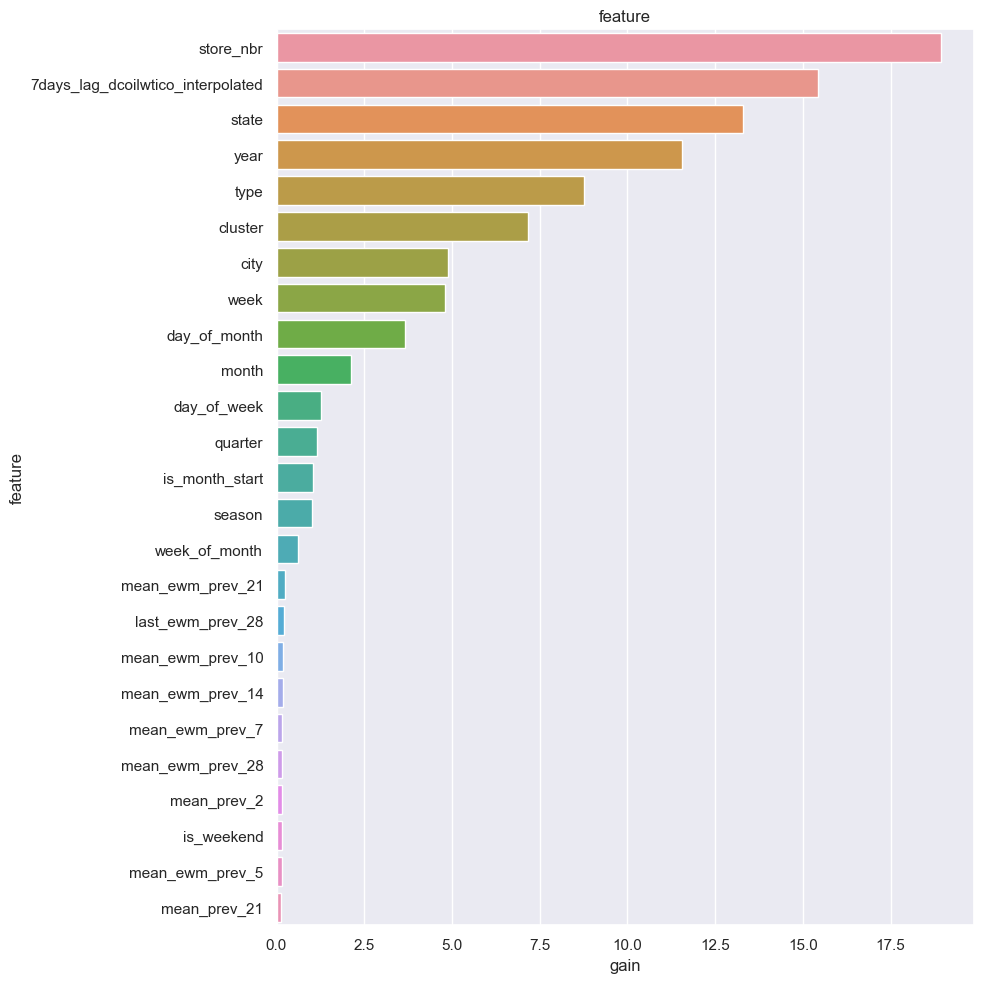

                               feature  split       gain
80                           store_nbr    878  18.931188
153  7days_lag_dcoilwtico_interpolated   1306  15.418937
98                               state    395  13.305996
82                                year    269  11.550703
99                                type    221   8.754973
100                            cluster    436   7.173516
97                                city    399   4.898418
84                                week    879   4.790953
87                        day_of_month    813   3.670138
83                               month    472   2.120696


In [7]:
# Load the model of your choice
family_number=1
model=load_model(DECISIONTREE_PATH,f'lgbm_valid_{family_number}.pkl')

# Show top x features, ordered by importances
plot_lgb_importances(model,20)

## Train the models on full data

Once we are happy with our results, we are rerunning the training but on the full data.
We are using the previous model tuned parameters and iterations.

In [8]:
cols_no_fam = [col for col in df_feats.columns if col not in ['date', 'id', "sales", "day",'target','family']] # List of columns we want to keep as features

# Loop through families
for fam in df_feats['family'].unique():

    # Create temp dataframes
    temp=df_feats[df_feats['family']==fam]
    Y_train_temp = temp['sales']
    X_train_temp = temp[cols_no_fam]

    # Load the model
    model=load_model(DECISIONTREE_PATH,f'lgbm_valid_{fam}.pkl')
    # Retrieve the model parameters - Remove the early_stopping_round as it is for validation only
    param= model.params
    try:
        param.pop('early_stopping_round')
    except:
        param=param

    # Create Train dataset
    lgbtrain = lgb.Dataset(data=X_train_temp, label=Y_train_temp, feature_name=cols_no_fam)

    # Train the model
    final_model = lgb.train(params=param,
                  train_set=lgbtrain,
                  num_boost_round=model.best_iteration,
                  feval=rmsle_lgbm)

    # Save the model
    save_model(DECISIONTREE_PATH,model,f'lgbm_all_{fam}.pkl')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 87696, number of used features: 98
[LightGBM] [Info] Start training from score 6.167294
Model has been saved in the following location C:/Users/lcauche/Documents/kaggle-store-sales/models/decision_tree\lgbm_all_0.pkl
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 87696, number of used features: 94
[LightGBM] [Info] Start training from score 0.114612
[LightGBM] [Warning] No further splits with positive ga

# Submission

In [9]:
submission=pd.DataFrame() # Submission Dataframe
cols_no_fam = [col for col in df_feats.columns if col not in ['date', 'id', "sales", "day",'target','family']] # List of columns we want to keep as features

# Loop through families
for fam in df_feats['family'].unique():

    # Load model
    final_model=load_model(DECISIONTREE_PATH,f'lgbm_all_{fam}.pkl')

    # Loop through store_nbr - use for the average zeroes approach
    for sto in df_feats.store_nbr.unique():

        # Create temp dataframes
        temp=df_test_feats[(df_test_feats['family']==fam) & (df_test_feats['store_nbr']==sto)]
        temp_test = test[(test['family']==df_le[df_le['family_le']==fam].family.item()) & (test['store_nbr']==sto)]
        temp_test = temp_test.loc[temp_test.sales.isna()]
        X_test = temp[cols_no_fam]
        train_temp=df_feats[(df_feats['family']==fam) & (df_feats['store_nbr']==sto)]

        # Run prediction for the serie
        test_preds = final_model.predict(X_test, num_iteration=final_model.best_iteration)

        # Zeroes the prediction
        for i in range(len(test_preds)):

            # No negative values
            test_preds[i]=max(0,test_preds[i])

            # If last 21 days are 0s then 0
            if train_temp.loc[-21:].sales.sum()==0:
                try:
                    test_preds.loc[i]=0
                except:
                    test_preds[i]=0

        # Take only ID and Sales 
        submission_df = temp_test.loc[:, ['id', 'sales']]
        submission_df['sales'] = test_preds
        submission_df['id'] = submission_df.id.astype(int)        
        submission=submission.append(submission_df)

In [10]:
#Sort by id
submission=submission.sort_values('id')

#Saving the submission file !!!Update the name of the file!!!
submission.to_csv(SUBMISSION_PATH/'submission_lgbm_12.csv', index=False)